# Benchmark 

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
from scipy import sparse

# from matplotlib import font_manager, rcParams
# custom_rc = {
#     'font.family': 'DejaVu Sans',
# }

# mpl.rcParams['svg.fonttype'] = 'none'
# mpl.rcParams['pdf.fonttype'] = 42

In [7]:
proj_name = "immune_DominguezConde"
file_name = "immune_DominguezConde"
file_suffix = time.strftime('%b%d-%H%M')

save_dir = Path(f"../save/{proj_name}-{file_suffix}")
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)

seed = 0
ccd.ul.set_seed(seed)

In [4]:
# load the data
adata = sc.read_h5ad(data_dir / f"{file_name}.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 329762 × 36398
    obs: 'donor_id', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'Manually_curated_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'cell_type_ontology_term_id_colors', 'citation', 'default_embedding', 'schema_reference', 'schema_version', 'sex_ontology_term_id_colors', 'title'
    obsm: 'X_umap'
    layers: 'counts'

### preprocessing

In [6]:
# ---------------------- Config ----------------------
MIN_GENES = 300
MIN_CELLS_PER_GENE = 5
N_TOP_HVG = 5000
N_PCS = 300

# ---------------------- Restart from Raw ----------------------
adata = adata.raw.to_adata()
print(f"✅ Restarted from raw: {adata.shape}")

# ---------------------- Add 'counts' Layer ----------------------
# Ensure integer counts and store them
if not np.issubdtype(adata.X.dtype, np.integer):
    adata.X = adata.X.astype("int32")
adata.layers["counts"] = adata.X.copy()

# ---------------------- QC Metrics ----------------------
sc.pp.calculate_qc_metrics(adata, inplace=True)

✅ Restarted from raw: (329762, 36398)


In [8]:
adata.obs['batch'] = (
    adata.obs['donor_id'].astype(str) + "_" +
    adata.obs['assay'].astype(str)
)

In [9]:
adata

AnnData object with n_obs × n_vars = 329762 × 36398
    obs: 'donor_id', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'Manually_curated_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch'
    var: 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts'

In [10]:
adata.obs['batch'].value_counts().to_dict()

{"D496_10x 3' v3": 88057,
 "D503_10x 3' v3": 79004,
 "640C_10x 5' v2": 35527,
 "637C_10x 5' v2": 25843,
 "A36_10x 5' v1": 24105,
 "A29_10x 5' v1": 17327,
 "A31_10x 5' v1": 12446,
 "582C_10x 5' v2": 11590,
 "A35_10x 5' v1": 11105,
 "621B_10x 5' v2": 10632,
 "A37_10x 5' v1": 9806,
 "A52_10x 5' v1": 4320}

In [11]:
# ---------------------- Cell Filtering ----------------------
adata = adata[adata.obs.n_genes_by_counts > MIN_GENES, :]
adata.write(data_dir / f"{file_name}_preprocessed.h5ad")
adata.shape

(329762, 36398)

In [12]:
# ---------------------- Gene Filtering ----------------------
sc.pp.filter_genes(adata, min_cells=MIN_CELLS_PER_GENE)
adata.shape

(329762, 29258)

In [13]:
# ---------------------- Set Filtered Raw ----------------------
adata.raw = adata.copy()

# ---------------------- Normalize & Log Transform ----------------------
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# ---------------------- Highly Variable Genes ----------------------
sc.pp.highly_variable_genes(
    adata,
    flavor='seurat_v3',
    n_top_genes=N_TOP_HVG,
    subset=False
)

# ---------------------- PCA ----------------------
sc.tl.pca(
    adata,
    n_comps=N_PCS,
    svd_solver='arpack',
    use_highly_variable=True
)

# ---------------------- Subset to HVGs ----------------------
adata = adata[:, adata.var.highly_variable].copy()
adata.write(data_dir / f"{file_name}_preprocessed_HVG.h5ad")  # after HVG subsetting

print(f"✅ Preprocessing complete: {adata.shape}. 'counts' saved in layers and raw.")

✅ Preprocessing complete: (329762, 5000). 'counts' saved in layers and raw.


### run integration methods

In [5]:
adata = sc.read_h5ad(data_dir / f"{file_name}_preprocessed_HVG.h5ad")

In [6]:
adata

AnnData object with n_obs × n_vars = 329762 × 5000
    obs: 'donor_id', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'Manually_curated_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch'
    var: 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts',

In [7]:
import subprocess, json
methods = ["unintegrated", "harmony", "liger", "scanorama", "scvi", "contrastive", "concord_knn", "concord_hcl"]

# concord_args = {
#     "encoder_dims": [512, 256],
#     "beta": 0.1,
#     "n_epochs": 10
# }

output_dir = '../jobs'
device = 'auto'
conda_env = 'concord_env'
batch_key = 'batch'  # Use the same batch key as in the notebook  
state_key = 'cell_type'
latent_dim = '50'  # Adjust as needed, but should match the encoder_dims in concord_args

mode = 'local'

subprocess.run([
    "python", "./generate_py_jobs.py",
    "--proj_name", proj_name,
    "--adata_filename", f"{file_name}_preprocessed_HVG.h5ad",
    "--methods", *methods,
    "--batch_key", batch_key,
    "--state_key", state_key,
    "--latent_dim", latent_dim,
    "--output_dir", output_dir,
    "--device", device,
    "--conda_env", conda_env,
    "--runtime", "02:00:00",
    "--mode", mode,
    # "--concord_kwargs", json.dumps(concord_args)
    "--verbose"
], check=True)

✅ Generated: benchmark_immune_DominguezConde/benchmark_immune_DominguezConde_unintegrated.py
✅ Generated: benchmark_immune_DominguezConde/benchmark_immune_DominguezConde_unintegrated.sh

✅ Generated: benchmark_immune_DominguezConde/benchmark_immune_DominguezConde_harmony.py
✅ Generated: benchmark_immune_DominguezConde/benchmark_immune_DominguezConde_harmony.sh

✅ Generated: benchmark_immune_DominguezConde/benchmark_immune_DominguezConde_liger.py
✅ Generated: benchmark_immune_DominguezConde/benchmark_immune_DominguezConde_liger.sh

✅ Generated: benchmark_immune_DominguezConde/benchmark_immune_DominguezConde_scanorama.py
✅ Generated: benchmark_immune_DominguezConde/benchmark_immune_DominguezConde_scanorama.sh

✅ Generated: benchmark_immune_DominguezConde/benchmark_immune_DominguezConde_scvi.py
✅ Generated: benchmark_immune_DominguezConde/benchmark_immune_DominguezConde_scvi.sh

✅ Generated: benchmark_immune_DominguezConde/benchmark_immune_DominguezConde_contrastive.py
✅ Generated: benchm

CompletedProcess(args=['python', './generate_py_jobs.py', '--proj_name', 'immune_DominguezConde', '--adata_filename', 'immune_DominguezConde_preprocessed_HVG.h5ad', '--methods', 'unintegrated', 'harmony', 'liger', 'scanorama', 'scvi', 'contrastive', 'concord_knn', 'concord_hcl', '--batch_key', 'batch', '--state_key', 'cell_type', '--latent_dim', '50', '--output_dir', '../jobs', '--device', 'auto', '--conda_env', 'concord_env', '--runtime', '02:00:00', '--mode', 'local', '--verbose'], returncode=0)

In [8]:
proj_folder = Path(output_dir) / f"benchmark_{proj_name}"
proj_folder.mkdir(parents=True, exist_ok=True)  # defensive

submit_all = proj_folder / f"submit_all_{proj_name}.sh"

with submit_all.open("w") as f:
    f.write("#!/bin/bash\n")
    f.write("# Auto-generated — sequentially runs every benchmark Python file\n")
    f.write('cd "$(dirname "$0")"\n\n')

    f.write("source ~/.bashrc\n")
    f.write("conda activate concord_env\n\n")    
    f.write("timestamp=$(date +'%m%d-%H%M')\n\n")

    # Set the Python executable to use
    f.write('py_exec="${PYTHON_EXEC:-python}"\n\n')

    for py_file in sorted(proj_folder.glob(f"benchmark_{proj_name}_*.py")):
        base = py_file.stem
        f.write(f"echo '🔄 Running: {py_file.name} (log: {base}_${{timestamp}}.log)'\n")
        f.write(f"${{py_exec}} {py_file.name} > {base}_${{timestamp}}.log 2>&1\n")
        f.write("echo '✅ Done.'\n\n")
        
submit_all.chmod(0o755)
print(f"📌  Next step: Run “{submit_all}” to execute all batch integration methods sequentially.")

📌  Next step: Run “../jobs/benchmark_immune_DominguezConde/submit_all_immune_DominguezConde.sh” to execute all batch integration methods sequentially.


In [20]:
# Run “{submit_all}” to execute all batch integration methods sequentially.
!bash {submit_all}

🔄 Running: benchmark_immune_DominguezConde_concord_hcl.py (log: benchmark_immune_DominguezConde_concord_hcl_${timestamp}.log)
✅ Done.
🔄 Running: benchmark_immune_DominguezConde_contrastive.py (log: benchmark_immune_DominguezConde_contrastive_${timestamp}.log)
✅ Done.
🔄 Running: benchmark_immune_DominguezConde_harmony.py (log: benchmark_immune_DominguezConde_harmony_${timestamp}.log)
✅ Done.
🔄 Running: benchmark_immune_DominguezConde_liger.py (log: benchmark_immune_DominguezConde_liger_${timestamp}.log)
✅ Done.
🔄 Running: benchmark_immune_DominguezConde_scanorama.py (log: benchmark_immune_DominguezConde_scanorama_${timestamp}.log)
✅ Done.
🔄 Running: benchmark_immune_DominguezConde_scvi.py (log: benchmark_immune_DominguezConde_scvi_${timestamp}.log)
✅ Done.
🔄 Running: benchmark_immune_DominguezConde_unintegrated.py (log: benchmark_immune_DominguezConde_unintegrated_${timestamp}.log)
✅ Done.


In [10]:
!bash {submit_all}

🔄 Running: benchmark_immune_DominguezConde_concord_knn.py (log: benchmark_immune_DominguezConde_concord_knn_${timestamp}.log)
✅ Done.


----

In [4]:
# load adata with genes without HVG selection
adata = sc.read_h5ad(data_dir / f"{file_name}_preprocessed.h5ad")

methods = ["unintegrated", "liger", "harmony", "scanorama", "scvi", "contrastive", "concord_knn", "concord_hcl"]

In [5]:
adata

AnnData object with n_obs × n_vars = 329762 × 36398
    obs: 'donor_id', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'Manually_curated_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch'
    var: 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts'

In [6]:
from benchmark_utils import add_embeddings

adata = add_embeddings(adata, proj_name=proj_name, methods=methods)

✅ obsm['unintegrated'] loaded
✅ obsm['liger'] loaded
✅ obsm['harmony'] loaded
✅ obsm['scanorama'] loaded
✅ obsm['scvi'] loaded
✅ obsm['contrastive'] loaded
✅ obsm['concord_knn'] loaded
✅ obsm['concord_hcl'] loaded


In [7]:
adata

AnnData object with n_obs × n_vars = 329762 × 36398
    obs: 'donor_id', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'Manually_curated_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch'
    var: 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts'

In [8]:
# save adata with all embeddings
adata.write_h5ad(data_dir / f"{file_name}_final.h5ad")

----

In [21]:
methods = ["scvi", "harmony", "scanorama", "liger", "unintegrated", "concord_hcl", "contrastive"]

In [22]:
# map the obsm back to the adata 
# for each method, uses the most recent run (based on timestamp)
# methods = ["scvi", "harmony", "scanorama", "liger", "unintegrated", "concord_hcl", "concord_knn", "contrastive"]

from benchmark_utils import add_embeddings

adata = add_embeddings(adata, proj_name=proj_name, methods=methods)



✅ obsm['scvi'] loaded
✅ obsm['harmony'] loaded
✅ obsm['scanorama'] loaded
✅ obsm['liger'] loaded
✅ obsm['unintegrated'] loaded
✅ obsm['concord_hcl'] loaded
✅ obsm['contrastive'] loaded


In [23]:
for method in methods:
    if f"{method}_UMAP" in adata.obsm:
        print(f"[⚠️ Warning] obsm['{method}_UMAP'] already exists, skipping UMAP computation")
    else:
        print(f"Computing 2D UMAP for {method}...")
        ccd.ul.run_umap(adata, source_key=f"{method}", result_key=f"{method}_UMAP", n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
        print(f"✅ obsm['{method}_UMAP'] computed")
    if f"{method}_UMAP_3D" in adata.obsm:
        print(f"[⚠️ Warning] obsm['{method}_UMAP_3D'] already exists, skipping UMAP computation")
    else:
        print(f"Computing 3D UMAP for {method}...")
        ccd.ul.run_umap(adata,source_key=f"{method}",result_key=f"{method}_UMAP_3D",n_components=3,  min_dist=0.1, metric='euclidean', random_state=seed)
        print(f"✅ obsm['{method}_UMAP_3D'] computed")

ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")
print(f"✅ Embeddings saved to {save_dir / f'obsm_{file_suffix}.h5'}")
final_path = data_dir / f"{file_name}_final.h5ad"
adata.write_h5ad(final_path)
print(f"✅ Final AnnData saved to: {final_path}")

Computing 2D UMAP for scvi...
concord - INFO - UMAP embedding stored in adata.obsm['scvi_UMAP']
✅ obsm['scvi_UMAP'] computed
Computing 3D UMAP for scvi...
concord - INFO - UMAP embedding stored in adata.obsm['scvi_UMAP_3D']
✅ obsm['scvi_UMAP_3D'] computed
Computing 2D UMAP for harmony...
concord - INFO - UMAP embedding stored in adata.obsm['harmony_UMAP']
✅ obsm['harmony_UMAP'] computed
Computing 3D UMAP for harmony...
concord - INFO - UMAP embedding stored in adata.obsm['harmony_UMAP_3D']
✅ obsm['harmony_UMAP_3D'] computed
Computing 2D UMAP for scanorama...
concord - INFO - UMAP embedding stored in adata.obsm['scanorama_UMAP']
✅ obsm['scanorama_UMAP'] computed
Computing 3D UMAP for scanorama...
concord - INFO - UMAP embedding stored in adata.obsm['scanorama_UMAP_3D']
✅ obsm['scanorama_UMAP_3D'] computed
Computing 2D UMAP for liger...
concord - INFO - UMAP embedding stored in adata.obsm['liger_UMAP']
✅ obsm['liger_UMAP'] computed
Computing 3D UMAP for liger...
concord - INFO - UMAP emb

concord.plotting.pl_embedding - INFO - Plotting scvi with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting harmony with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting scanorama with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting liger with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting unintegrated with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting contrastive with batch in UMAP


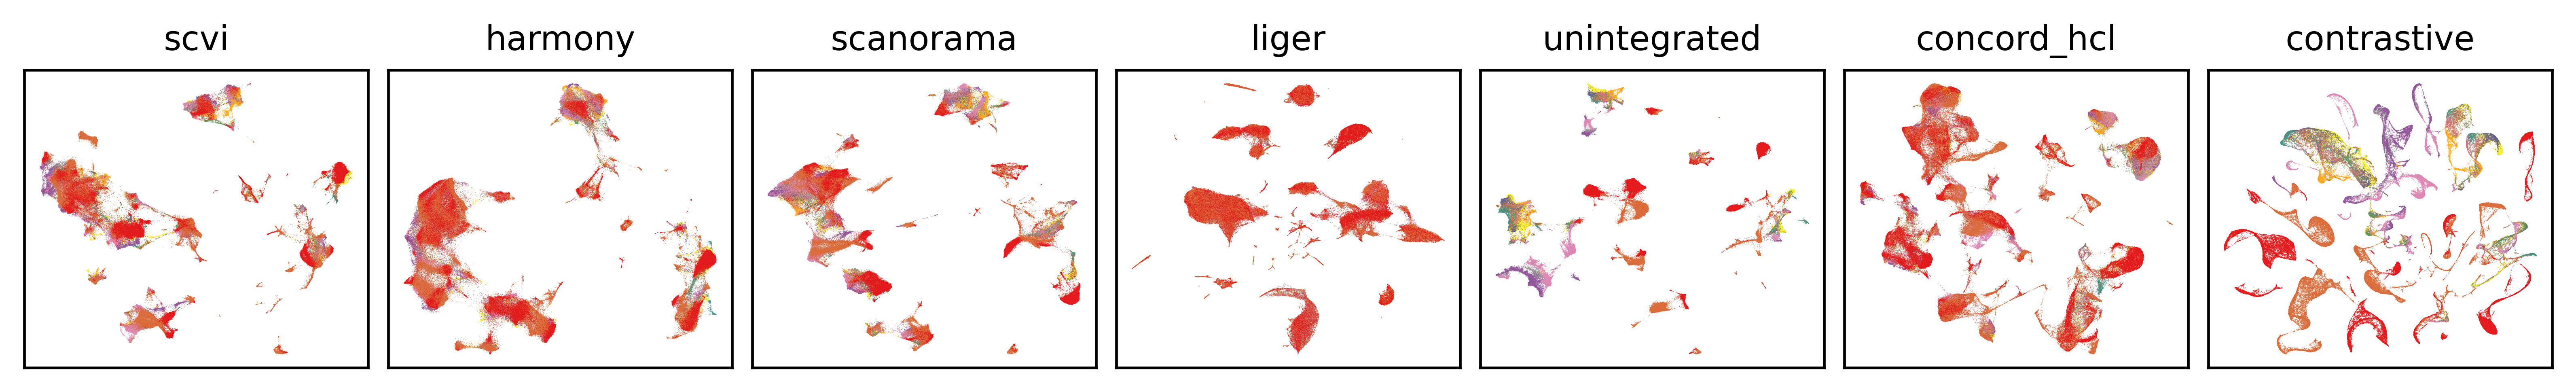

concord.plotting.pl_embedding - INFO - Plotting scvi with cell_type in UMAP
concord.plotting.pl_embedding - INFO - Plotting harmony with cell_type in UMAP
concord.plotting.pl_embedding - INFO - Plotting scanorama with cell_type in UMAP
concord.plotting.pl_embedding - INFO - Plotting liger with cell_type in UMAP
concord.plotting.pl_embedding - INFO - Plotting unintegrated with cell_type in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with cell_type in UMAP
concord.plotting.pl_embedding - INFO - Plotting contrastive with cell_type in UMAP


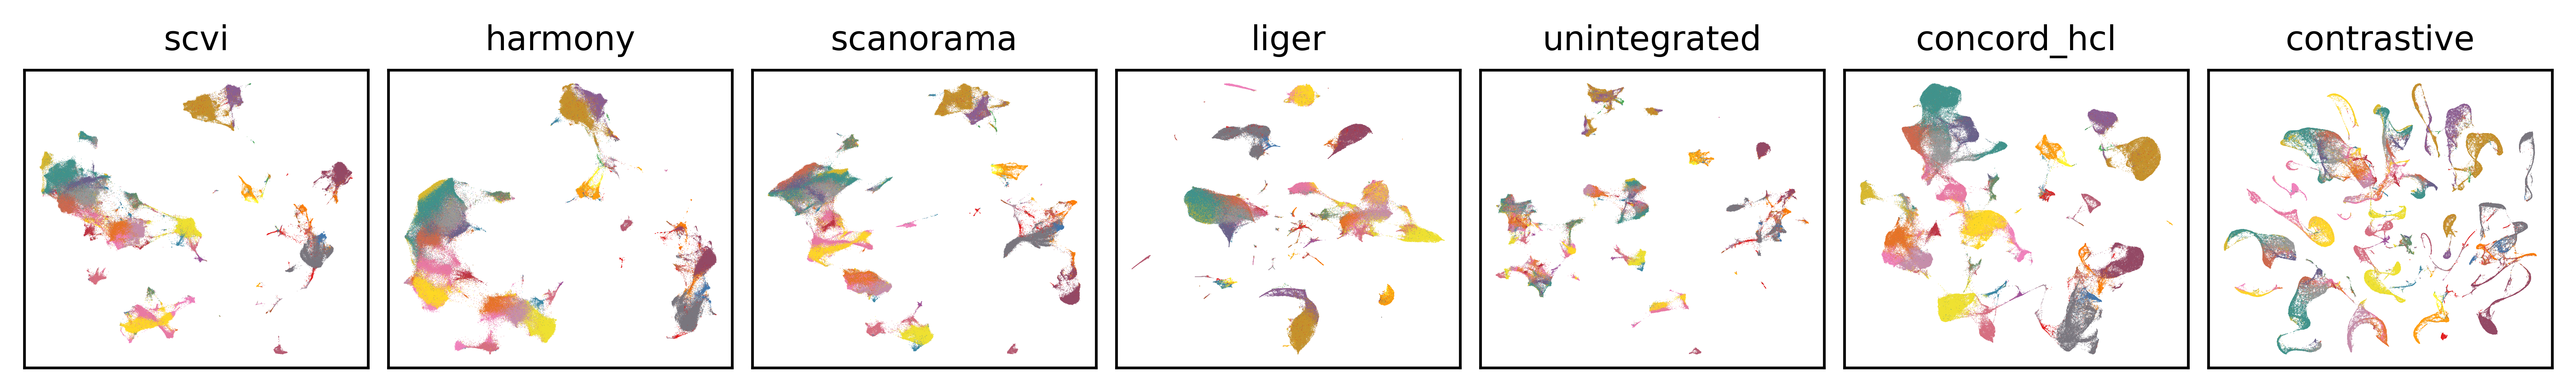

In [24]:
# plot everything
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# Set DejaVu Sans as the default font
custom_rc = {
    'font.family': 'DejaVu Sans',  # Set the desired font for this plot
}

show_keys = methods
show_cols = [batch_key, state_key]
basis_types = ['UMAP']

font_size=10
point_size=.1
alpha=0.8
ncols = len(show_keys)
figsize=(ncols * 1.5,1.5)
nrows = int(np.ceil(len(show_keys) / ncols))
pal = {'donor_id': 'Set1', 
       'cell_type': 'Set1'}

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=show_cols,
        basis_types=basis_types,
        pal=pal,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        save_dir=save_dir,
        file_suffix=file_suffix,
        dpi=600,
        save_format='svg'
    )


In [ ]:
output_key = 'concord_hcl'
basis = output_key
show_basis = basis + '_UMAP'
show_cols = ['donor_id', 'cell_type']
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_embedding(
        adata, show_basis, show_cols, figsize=(8,4), dpi=600, ncols=2, font_size=4, point_size=0.5, legend_loc='on data',
        pal = pal, seed=seed,
        save_path=save_dir / f"{show_basis}_{file_suffix}_wttext.pdf"
    )

In [29]:
adata.var['feature_name']

ENSG00000223764                 LINC02593
ENSG00000188290      HES4_ENSG00000188290
ENSG00000187608     ISG15_ENSG00000187608
ENSG00000237330    RNF223_ENSG00000237330
ENSG00000223823                 LINC01342
                            ...          
ENSG00000277475         ENSG00000277475.1
ENSG00000277856         ENSG00000277856.1
ENSG00000275063         ENSG00000275063.1
ENSG00000277836         ENSG00000277836.1
ENSG00000277196         ENSG00000277196.4
Name: feature_name, Length: 5000, dtype: category
Categories (5000, object): ['A1CF_ENSG00000148584', 'A2M-AS1', 'A2ML1-AS1', 'A2ML1-AS2', ..., 'ZNF727_ENSG00000214652', 'ZNF750_ENSG00000141579', 'ZNF80_ENSG00000174255', 'ZNF831_ENSG00000124203']

In [30]:
# Keep original var_names just in case
adata.var['ensembl_id'] = adata.var_names

# Extract gene symbols from 'feature_name' (before underscore)
adata.var_names = adata.var['feature_name']

In [32]:
ccd.ul.anndata_to_viscello(adata, data_dir / f"cello_{proj_name}_{file_suffix}", project_name = proj_name, organism='hsa')
print(f"Saved viscello to {data_dir / f'cello_{proj_name}_{file_suffix}'}")

VisCello project created at ../data/immune_DominguezConde/cello_immune_DominguezConde_Jul02-2046
Saved viscello to ../data/immune_DominguezConde/cello_immune_DominguezConde_Jul02-2046


# Benchmarking

In [5]:
methods = ["unintegrated", "liger", "harmony", "scanorama", "scvi", "contrastive", "concord_knn", "concord_hcl"]

✅ Benchmark summary saved to: ../save/immune_DominguezConde-Jul07-1701/benchmark_summary_Jul07-1701.tsv


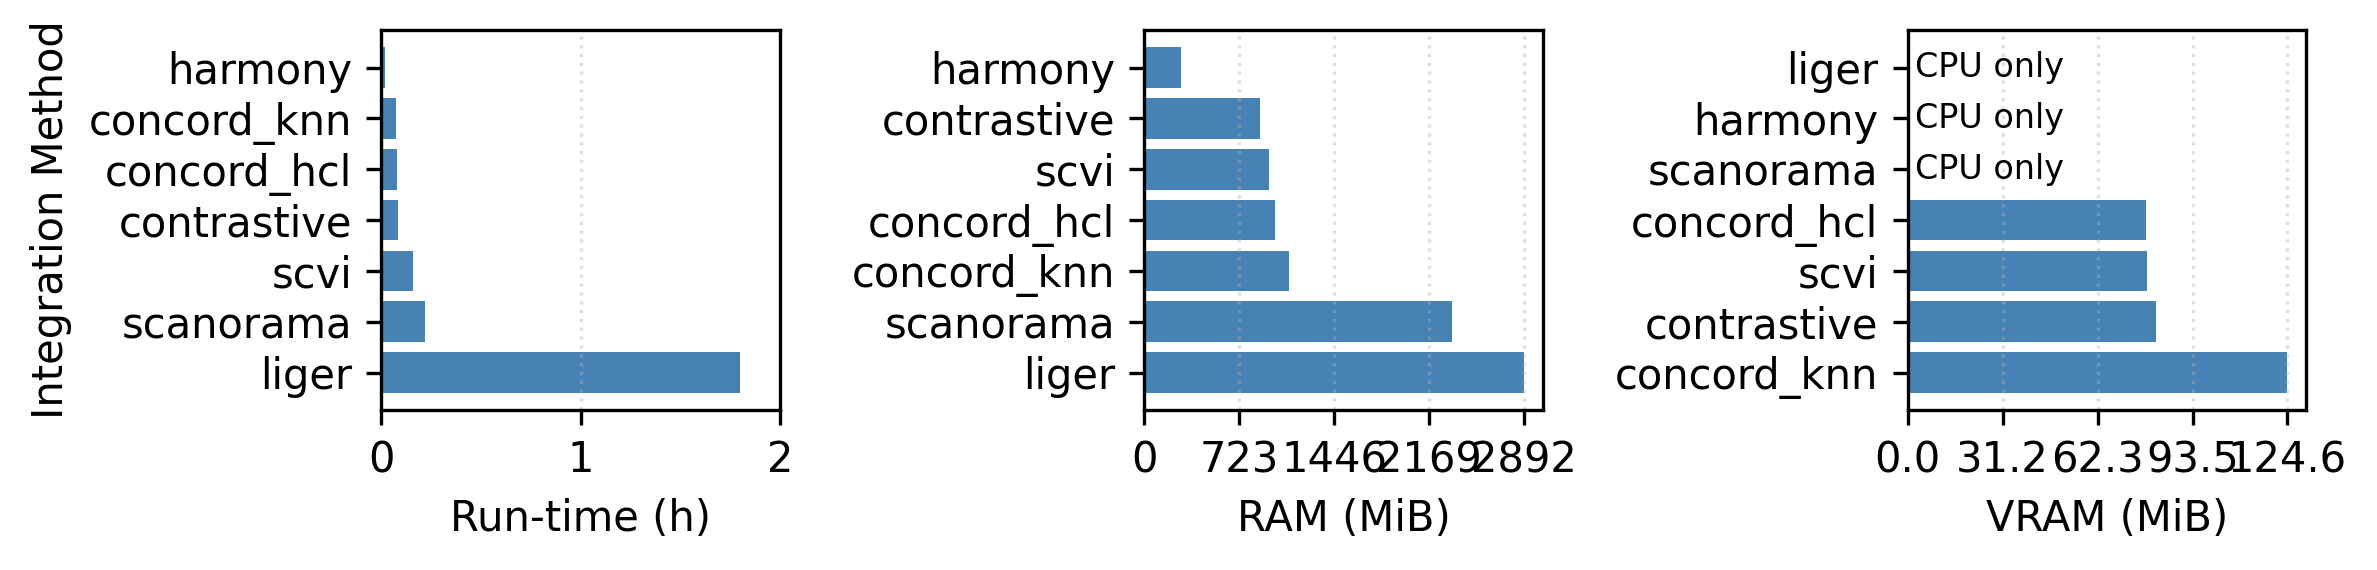

In [9]:
from benchmark_utils import collect_benchmark_logs
bench_df = collect_benchmark_logs("immune_DominguezConde", methods)
# Save the benchmark results
bench_df.to_csv(save_dir / f"benchmark_summary_{file_suffix}.tsv", sep="\t", index=False)
print(f"✅ Benchmark summary saved to: {save_dir / f'benchmark_summary_{file_suffix}.tsv'}")
# Plot benchmark results
from benchmark_utils import plot_benchmark_performance
import matplotlib.pyplot as plt
custom_rc = {
    'font.family': 'DejaVu Sans',  # Set the desired font for this plot
}
with plt.rc_context(rc=custom_rc):
    plot_benchmark_performance(bench_df, figsize=(8,2), dpi=300, save_path = save_dir / f"benchmark_plot_{file_suffix}.pdf")


concord.benchmarking.benchmark - INFO - Running SCIB benchmark


Embeddings: 100%|██████████| 7/7 [1:18:50<00:00, 675.75s/it]


concord.benchmarking.benchmark - INFO - Running Probe benchmark
concord.benchmarking.benchmark - INFO - Running linear probe for state with keys ['scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'contrastive']
Detected task: classification
concord.benchmarking.benchmark - INFO - Running linear probe for batch with keys ['scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'contrastive']
Detected task: classification
concord.benchmarking.benchmark - INFO - Running k-NN probe for state with keys ['scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'contrastive']
[KNN] detected task: classification
concord.benchmarking.benchmark - INFO - Running k-NN probe for batch with keys ['scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'contrastive']
[KNN] detected task: classification


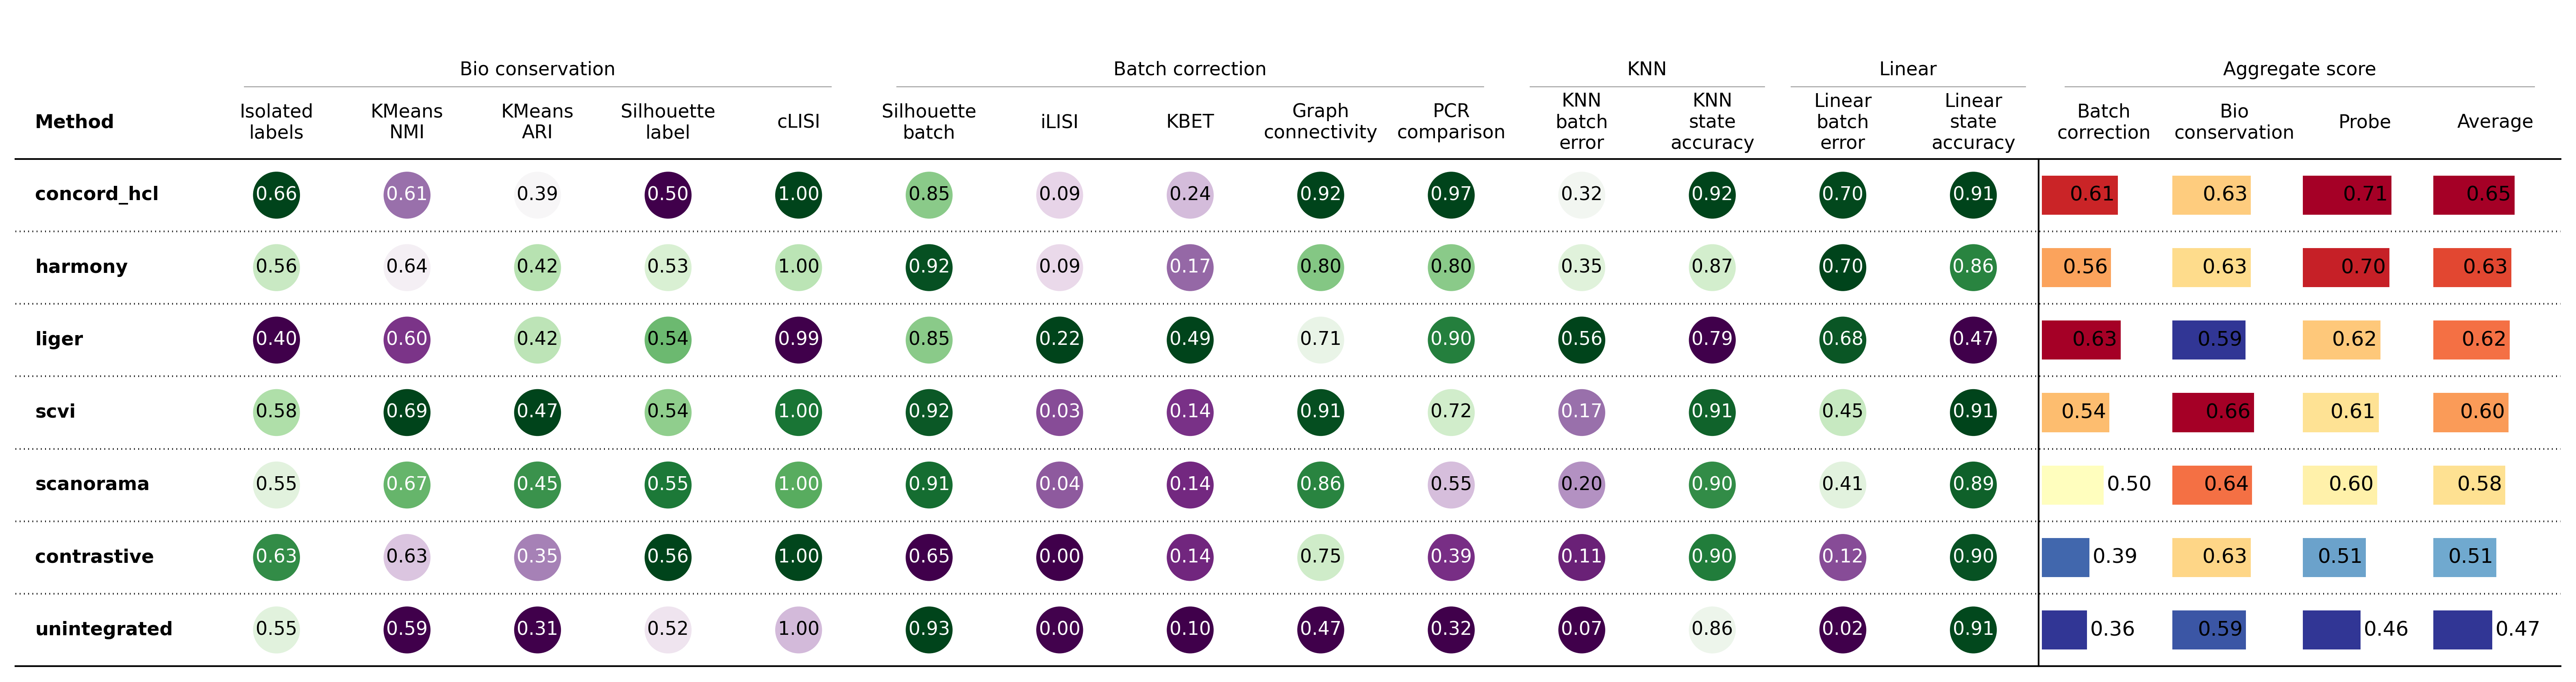

✅ Benchmark results saved to: ../save/immune_DominguezConde-Jul02-2046/benchmark_cell_type_Jul02-2046.pkl


In [34]:
# Run the benchmark pipeline
out = ccd.bm.run_benchmark_pipeline(
    adata,
    embedding_keys=methods,
    state_key=state_key,
    batch_key=batch_key,
    save_dir=save_dir / "benchmarks_celltype",
    file_suffix=file_suffix,  # e.g. "2025-06-25"
    run=("scib","probe"),          # run only these blocks
    plot_individual=False,          # skip the intermediate PDFs
)
combined_celltype = out["combined"]

# Save the benchmark results
import pickle
with open(save_dir / f"benchmark_{state_key}_{file_suffix}.pkl", "wb") as f:
    pickle.dump(out, f)

print(f"✅ Benchmark results saved to: {save_dir / f'benchmark_{state_key}_{file_suffix}.pkl'}")